#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [ ]:
!which python

/opt/anaconda3/envs/csma3/bin/python


# Install dependencies:

In [ ]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

In [2]:
!pip install scikit-learn-extra

     |████████████████████████████████| 624kB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340328 sha256=0e5fcb9564f9974daf7e12bb2922e19e8ff85c1a114836c50d2e1ac6a80d44b7
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


# Imports

In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [64]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [70]:
save_results()

In [5]:
# Set pandas print options
This will improve readability of printed pandas dataframe.


SyntaxError: ignored

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [10]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.54145825
n_clusters: 102 silhouette_avg: 0.3079367
n_clusters: 202 silhouette_avg: 0.29206014
n_clusters: 302 silhouette_avg: 0.27912095
n_clusters: 402 silhouette_avg: 0.26181304
n_clusters: 502 silhouette_avg: 0.24450187
n_clusters: 602 silhouette_avg: 0.20956671
n_clusters: 702 silhouette_avg: 0.16347073
n_clusters: 802 silhouette_avg: 0.10457735
n_clusters: 902 silhouette_avg: 0.04809703


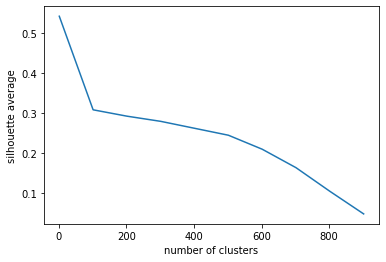

In [22]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=2500 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [27]:
number_of_clusters =  20
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 19    12
15    16
7     18
12    18
14    22
13    32
4     33
6     36
3     37
5     50
2     55
11    58
10    58
0     61
1     66
17    67
18    67
9     72
8     82
16    86
Name: label_kmedoids, dtype: int64


In [28]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [29]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

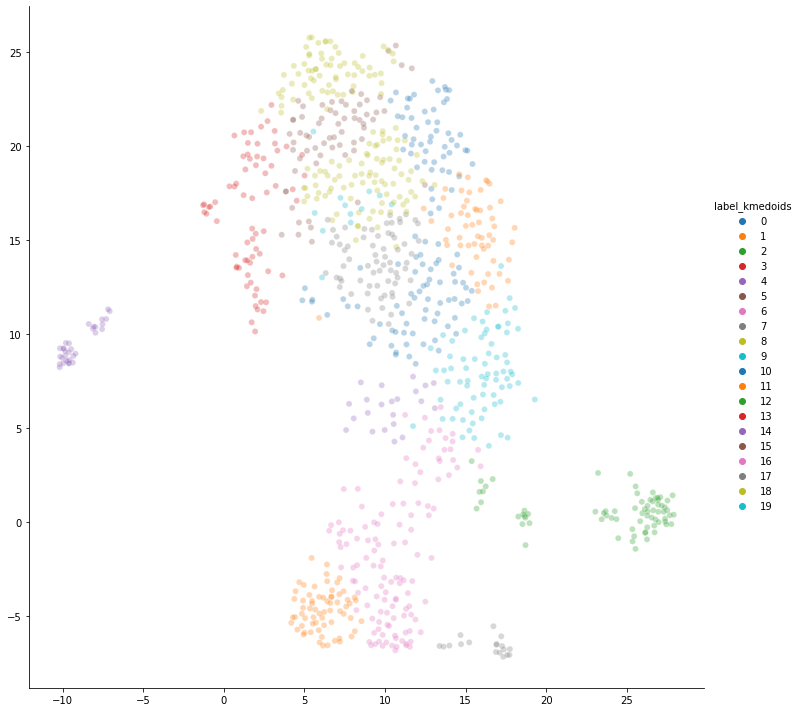

In [35]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "tab10" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.31 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

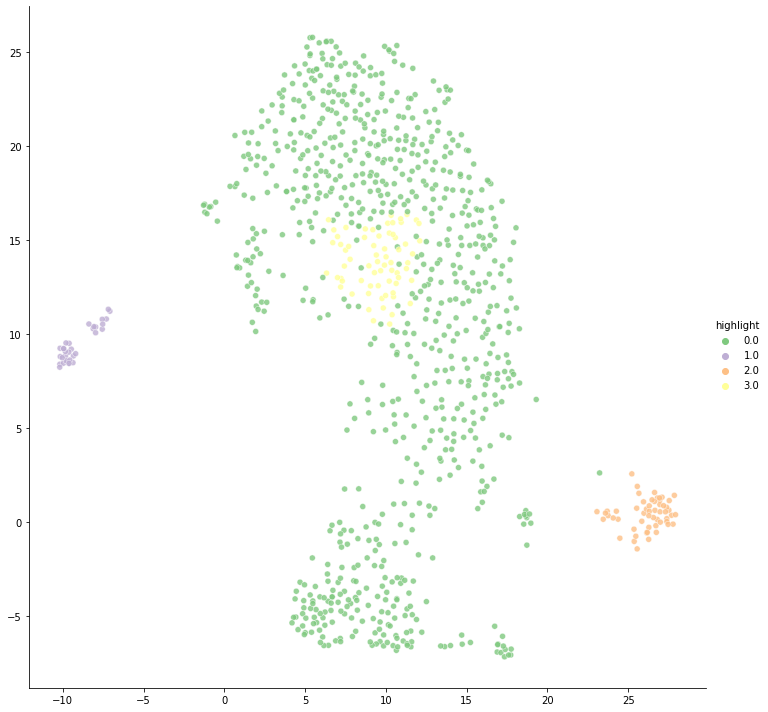

In [55]:
## Choose a cluster to higlight:
cluster_num = 4

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1
data.loc[data['label_kmedoids'] == 2, 'highlight'] = 2
data.loc[data['label_kmedoids'] == 17, 'highlight'] = 3

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [52]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
737,2020-01-18 10:40:26,charmy TV,"@Andreas Meier Den Klimawandel gibt es schon lange vor der Menschheit , ergo kann er nicht Menschen gemacht sein.",1,"@ Den Klimawandel gibt es schon lange vor der Menschheit , ergo\nkann er nicht Menschen gemacht sein.\n\n",-1.0,0,0.000000e+00,0.0
254,2020-01-17 17:04:45,Stuben Gamer,@Rosi Opp Sie lassen sich nicht Veraschn? Wieso fallen sie den auf die Lügen der AFD rein?=,1,@ Sie lassen sich nicht Veraschn? Wieso fallen sie den auf die Lügen\nder AFD rein?=\n\n,-1.0,1,5.960464e-08,0.0
103,2020-01-18 15:53:32,Onib Formi,"Es ist schon soviel CO2 in der Luft, das die Rückstrahlung der Erde in den spezifischen Absorptionsbanden vollständig absorbiert wird. Ein mehr an CO2 hat so gut wie keinen Effekt. Im Labor kann man einiges konstruieren, vor allem ,wenn man die Absorptionsbande von Wasserdampf/Luftfeuchtigkeit herausrechnet, welche die Absorptionsbande von CO2 zum großen Teil überlagern.",0,"Es ist schon soviel CO2 in der Luft, das die Rückstrahlung der Erde in den\nspezifischen Absorptionsbanden vollständig absorbiert wird. Ein mehr an CO2\nhat so gut wie keinen Effekt. Im Labor kann man einiges konstruieren, vor\nallem ,wenn man die Absorptionsbande von Wasserdampf/Luftfeuchtigkeit\nherausrechnet, welche die Absorptionsbande von CO2 zum großen Teil überlagern.\n\n",-1.0,2,0.000000e+00,2.0
43,2020-01-20 21:18:37,Alfred Wacker,Roth Kift,0,Roth Kift\n\n,-1.0,3,0.000000e+00,0.0
268,2020-01-17 14:02:55,Emma Aringer,👍👍👍🇩🇪💙🇩🇪❣🇩🇪💙🇩🇪,0,👍👍👍🇩🇪💙🇩🇪❣🇩🇪💙🇩🇪\n\n,-1.0,4,0.000000e+00,0.0
565,2020-01-16 14:36:25,Kurt Gruber,Hein Ruh … Wer weiß Wer weiß :-),1,… Wer weiß Wer weiß :-)\n\n,-1.0,5,0.000000e+00,0.0
455,2020-01-17 20:09:19,Test Kauf,"@Stuben Gamer Widerlege doch die zitierten Aussagen, statt einfach ""falsch"" zu schreiben oder veraltete populärwissenschaftliche Zeitschriften zu zitieren. denn es gibt tatsächlich kein Laborexperiment in diesem Bereich. Weswegen die These auch in allen Ländern außer Deutschland auch in den Medien umstritten ist.",1,"@ Widerlege doch die zitierten Aussagen, statt einfach ""falsch"" zu\nschreiben oder veraltete populärwissenschaftliche Zeitschriften zu zitieren.\ndenn es gibt tatsächlich kein Laborexperiment in diesem Bereich. Weswegen die\nThese auch in allen Ländern außer Deutschland auch in den Medien umstritten\nist.\n\n",-1.0,6,0.000000e+00,0.0
310,2020-01-17 01:56:46,T. END,"Steigenden Gefahr von Blackouts? Was ein Quatsch wir produzieren soviel Strom, dass wir ihn immernoch ins Ausland verkaufen.<br />Und an dieser &quot;ideologischen Agenda&quot; nehmen seit über 30 Jahren fast alle Nationen dieser Welt teil. Das machen die natürlich alle, weil sie keine Ahnung haben. Nicht wahr Herr Dr. Espendiller?<br /><br />Sie tun so als ob dieser Strukturwandel ganz plötzliche gekommen ist. Seit 40 Jahren bettelt die versammelte Gemeinschaft interdisziplinärer Wissenschaftler darum gehört zu werden. Was sie bis zu diesem Tage nicht wird.<br /><br /><br />Ihre Blackoutthese ist umso perfider, wenn man betrachtet, dass sich im Energiesektor seit Jahren nichts getan hat. Bis Heute nicht. <br /><br />Im Gegenteil. Sollarunternehmen werden von der Energielobby in der Bundesregierung klein gehalten, der Markt für regenerative Energie stagniert seit Jahren in Deutschland.<br />Die neuen Gesetze sind keine, weil sie von der &quot; deutschen&quot; Industrielobby kaputt geschrieben wurden.<br /><br /><br />Das einzige was im letzten Jahr passiert ist, ist das wir Plastiktüten und Strohhalme verboten haben.<br />All das läst einen zu nur einem Schluss kommen.<br /><br /><br />Sie sind ein Lügner.<br />Aber was soll man erwarten von einem Typen der mit 23 in eine Partein eintritt, seinen Doktor macht und nichts in der Welt zustande bekommen hat als genau eben das.<br />Ich mein war ihnen die freie Wirtschaft zu gruselig oder wollten sie sich nur eine Beamtenrente sichern?<br />Einen 

In [41]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  61 mean distance from center:  0.0053522038797382265 Proportion of replies: 50.81967213114754
1 number of samples:  66 mean distance from center:  0.0014026056305738166 Proportion of replies: 30.303030303030305
2 number of samples:  55 mean distance from center:  0.001235550098499516 Proportion of replies: 83.63636363636364
3 number of samples:  37 mean distance from center:  0.003281477256678045 Proportion of replies: 43.24324324324324
4 number of samples:  33 mean distance from center:  0.0012959494597453158 Proportion of replies: 48.484848484848484
5 number of samples:  50 mean distance from center:  0.0042438507080078125 Proportion of replies: 70.0
6 number of samples:  36 mean distance from center:  0.004056758189108223 Proportion of replies: 50.0
7 number of samples:  18 mean distance from center:  0.0015957488358253613 Proportion of replies: 16.666666666666668
8 number of samples:  82 mean distance from center:  0.004794394044438377 Proportion of replies: 6

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [61]:
# Choose a cluster to print
cluster_number =   2
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 55
Average Distance from cluster center: 1.235550098499516e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
103,2020-01-18 15:53:32,Onib Formi,"Es ist schon soviel CO2 in der Luft, das die Rückstrahlung der Erde in den spezifischen Absorptionsbanden vollständig absorbiert wird. Ein mehr an CO2 hat so gut wie keinen Effekt. Im Labor kann man einiges konstruieren, vor allem ,wenn man die Absorptionsbande von Wasserdampf/Luftfeuchtigkeit herausrechnet, welche die Absorptionsbande von CO2 zum großen Teil überlagern.",0,"Es ist schon soviel CO2 in der Luft, das die Rückstrahlung der Erde in den\nspezifischen Absorptionsbanden vollständig absorbiert wird. Ein mehr an CO2\nhat so gut wie keinen Effekt. Im Labor kann man einiges konstruieren, vor\nallem ,wenn man die Absorptionsbande von Wasserdampf/Luftfeuchtigkeit\nherausrechnet, welche die Absorptionsbande von CO2 zum großen Teil überlagern.\n\n",-1,2,0.000000e+00,2.0
104,2020-08-21 12:55:29,Der Keniry,"spezifischen Absorptionsbanden vollständig absorbiert wird. Das gilt aber nur für die bodennahen Luftschichten. Die Bandensättigung ist ein höhenabhängiges Phänomen und ab einer bestimmten Höhe sind sie eben *nicht mehr* gesättigt. Fügt man CO2 hinzu, wandert dieser Bereich weiter nach oben und der Höhenbereich, in dem CO2 absorbiert wird, wird immer größer. Damit kann auch *mehr* Strahlungsenergie gespeichert werden.",1,"spezifischen Absorptionsbanden vollständig absorbiert wird. Das gilt aber nur\nfür die bodennahen Luftschichten. Die Bandensättigung ist ein höhenabhängiges\nPhänomen und ab einer bestimmten Höhe sind sie eben *nicht mehr* gesättigt.\nFügt man CO2 hinzu, wandert dieser Bereich weiter nach oben und der\nHöhenbereich, in dem CO2 absorbiert wird, wird immer größer. Damit kann auch\n*mehr* Strahlungsenergie gespeichert werden.\n\n",-1,2,2.980232e-07,2.0
504,2020-01-16 20:22:56,Superglucke,"Die CO2 Emissionen von Vulkanausbrüchen sind vernachlässigbar. Das können Sie überall auf wissenschaftlichen Seiten nachlesen. Dass die globale Erderwärmung anthropogenen Ursprungs ist, ist so sicher wie die Evolutionstheorie, die Sie ja hoffentlich nicht auch in Frage stellen, oder?",1,"Die CO2 Emissionen von Vulkanausbrüchen sind vernachlässigbar. Das können Sie\nüberall auf wissenschaftlichen Seiten nachlesen. Dass die globale Erderwärmung\nanthropogenen Ursprungs ist, ist so sicher wie die Evolutionstheorie, die Sie\nja hoffentlich nicht auch in Frage stellen, oder?\n\n",-1,2,4.172325e-07,2.0
632,2020-01-16 20:04:00,Jakob Klaßen,"​@Mompfred Der hohe Gehalt an Co2 in der Atmosphäre sorgt dafür, dass die Sonnenstrahlen nicht ins All entfliehen, sondern zur Erde zurückkehren. Das ist der Treibhauseffekt. Und 97 Prozent der untersuchten Studien von John Cook, die sich zum Klimawandel äußern, bestätigen, dass es einen menschengemachten Klimawandel gibt.",1,"​@ Der hohe Gehalt an Co2 in der Atmosphäre sorgt dafür, dass die\nSonnenstrahlen nicht ins All entfliehen, sondern zur Erde zurückkehren. Das\nist der Treibhauseffekt. Und 97 Prozent der untersuchten Studien von John\nCook, die sich zum Klimawandel äußern, bestätigen, dass es einen\nmenschengemachten Klimawandel gibt.\n\n",-1,2,9.536743e-07,2.0
824,2020-02-27 10:09:52,CeedBeats,@Dr h c Groner medien Server 2 Grammatikalisch ist beides richtig. Sag Mal hast du noch irgendwas bezüglich CO2 Konzentration in der Atmosphäre zu sagen oder willst du jetzt hier die ganze Zeit nur rumjammern und mich beschimpfen. Ich melde das übrigens.,1,@ Grammatikalisch ist beides richtig. Sag Mal\nhast du noch irgendwas bezüglich CO2 Konzentration in der Atmosphäre zu sagen\noder willst du jetzt hier die ganze Zeit nur rumjammern und mich beschimpfen.\nIch melde das übrigens.\n\n,-1,2,1.251698e-06,2.0
805,2020-01-18 10:35:06,Fritz Bamert,"Bin nicht in allem gleicher Meinung, aber trotzdem, so jemand sollten wir auch in der Schweiz haben. Da getraut sich niemand offiziell hinzustehen und zu sagen dass der Menschengemachte Klimawandel auf einer Lüge beruht ( zu

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [62]:
#which cluster would you like to assign labels to?
cluster_number = 2
#your label
label_manual = 'CO2Discussion'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [67]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
103,2020-01-18 15:53:32,Onib Formi,"Es ist schon soviel CO2 in der Luft, das die Rückstrahlung der Erde in den spezifischen Absorptionsbanden vollständig absorbiert wird. Ein mehr an CO2 hat so gut wie keinen Effekt. Im Labor kann man einiges konstruieren, vor allem ,wenn man die Absorptionsbande von Wasserdampf/Luftfeuchtigkeit herausrechnet, welche die Absorptionsbande von CO2 zum großen Teil überlagern.",0,"Es ist schon soviel CO2 in der Luft, das die Rückstrahlung der Erde in den\nspezifischen Absorptionsbanden vollständig absorbiert wird. Ein mehr an CO2\nhat so gut wie keinen Effekt. Im Labor kann man einiges konstruieren, vor\nallem ,wenn man die Absorptionsbande von Wasserdampf/Luftfeuchtigkeit\nherausrechnet, welche die Absorptionsbande von CO2 zum großen Teil überlagern.\n\n",CO2Discussion,2,0.000000e+00,2.0
104,2020-08-21 12:55:29,Der Keniry,"spezifischen Absorptionsbanden vollständig absorbiert wird. Das gilt aber nur für die bodennahen Luftschichten. Die Bandensättigung ist ein höhenabhängiges Phänomen und ab einer bestimmten Höhe sind sie eben *nicht mehr* gesättigt. Fügt man CO2 hinzu, wandert dieser Bereich weiter nach oben und der Höhenbereich, in dem CO2 absorbiert wird, wird immer größer. Damit kann auch *mehr* Strahlungsenergie gespeichert werden.",1,"spezifischen Absorptionsbanden vollständig absorbiert wird. Das gilt aber nur\nfür die bodennahen Luftschichten. Die Bandensättigung ist ein höhenabhängiges\nPhänomen und ab einer bestimmten Höhe sind sie eben *nicht mehr* gesättigt.\nFügt man CO2 hinzu, wandert dieser Bereich weiter nach oben und der\nHöhenbereich, in dem CO2 absorbiert wird, wird immer größer. Damit kann auch\n*mehr* Strahlungsenergie gespeichert werden.\n\n",CO2Discussion,2,2.980232e-07,2.0
504,2020-01-16 20:22:56,Superglucke,"Die CO2 Emissionen von Vulkanausbrüchen sind vernachlässigbar. Das können Sie überall auf wissenschaftlichen Seiten nachlesen. Dass die globale Erderwärmung anthropogenen Ursprungs ist, ist so sicher wie die Evolutionstheorie, die Sie ja hoffentlich nicht auch in Frage stellen, oder?",1,"Die CO2 Emissionen von Vulkanausbrüchen sind vernachlässigbar. Das können Sie\nüberall auf wissenschaftlichen Seiten nachlesen. Dass die globale Erderwärmung\nanthropogenen Ursprungs ist, ist so sicher wie die Evolutionstheorie, die Sie\nja hoffentlich nicht auch in Frage stellen, oder?\n\n",CO2Discussion,2,4.172325e-07,2.0
632,2020-01-16 20:04:00,Jakob Klaßen,"​@Mompfred Der hohe Gehalt an Co2 in der Atmosphäre sorgt dafür, dass die Sonnenstrahlen nicht ins All entfliehen, sondern zur Erde zurückkehren. Das ist der Treibhauseffekt. Und 97 Prozent der untersuchten Studien von John Cook, die sich zum Klimawandel äußern, bestätigen, dass es einen menschengemachten Klimawandel gibt.",1,"​@ Der hohe Gehalt an Co2 in der Atmosphäre sorgt dafür, dass die\nSonnenstrahlen nicht ins All entfliehen, sondern zur Erde zurückkehren. Das\nist der Treibhauseffekt. Und 97 Prozent der untersuchten Studien von John\nCook, die sich zum Klimawandel äußern, bestätigen, dass es einen\nmenschengemachten Klimawandel gibt.\n\n",CO2Discussion,2,9.536743e-07,2.0
824,2020-02-27 10:09:52,CeedBeats,@Dr h c Groner medien Server 2 Grammatikalisch ist beides richtig. Sag Mal hast du noch irgendwas bezüglich CO2 Konzentration in der Atmosphäre zu sagen oder willst du jetzt hier die ganze Zeit nur rumjammern und mich beschimpfen. Ich melde das übrigens.,1,@ Grammatikalisch ist beides richtig. Sag Mal\nhast du noch irgendwas bezüglich CO2 Konzentration in der Atmosphäre zu sagen\noder willst du jetzt hier die ganze Zeit nur rumjammern und mich beschimpfen.\nIch melde das übrigens.\n\n,CO2Discussion,2,1.251698e-06,2.0
805,2020-01-18 10:35:06,Fritz Bamert,"Bin nicht in allem gleicher Meinung, aber trotzdem, so jemand sollten wir auch in der Schweiz haben. Da getraut sich niemand offiziell hinzustehen und zu sagen dass der 

In [68]:
data[data['label_kmedoids']==17].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
808,2020-01-16 13:08:25,Dr h c Groner medien Server 2,"Der Individualverkehr soll durch die Grünen,Roten,schwarzen Kommunisten abgeschafft werden. Darauf läuft es hinaus",0,"Der Individualverkehr soll durch die Grünen,Roten,schwarzen Kommunisten\nabgeschafft werden. Darauf läuft es hinaus\n\n",factsOrNot?,17,0.000000,3.0
134,2020-01-18 10:31:07,Straessers,"<a href=""https://www.youtube.com/watch?v=dtlOUMEz4y8&amp;t=3m57s"">3:57</a> Hauptsache einige Altparteien-Furien suchen sich Möglichkeiten um dazwischen zu kreischen, hier im Falle eines kleinen Versprechers.",0,"3:57 Hauptsache einige Altparteien-Furien suchen sich Möglichkeiten um\ndazwischen zu kreischen, hier im Falle eines kleinen Versprechers.\n\n",factsOrNot?,17,0.000004,3.0
273,2020-01-17 13:54:05,Jube,"Ja, die CO2-Gegner sterben am CO2...ihre Gehirne sind schon tot!",0,"Ja, die CO2-Gegner sterben am CO2...ihre Gehirne sind schon tot!\n\n",factsOrNot?,17,0.000005,3.0
170,2020-01-21 17:02:48,Superglucke,"Bis auf die Ausgangsprämisse, dass der anthropogene Klimawandel aus wissenschaftlicher Sicht noch bezweifelt wird.",1,"Bis auf die Ausgangsprämisse, dass der anthropogene Klimawandel aus\nwissenschaftlicher Sicht noch bezweifelt wird.\n\n",factsOrNot?,17,0.000005,3.0
923,2020-01-18 21:32:13,Michel,"Nachhilfeunterricht für Generationen,bis heute nicht dieses Theaterstück durchschaut",1,"Nachhilfeunterricht für Generationen,bis heute nicht dieses Theaterstück\ndurchschaut\n\n",factsOrNot?,17,0.000012,3.0
842,2020-02-26 22:54:24,CeedBeats,@Dr h c Groner medien Server 2 Atemluft ist nicht gleich Atmosphäre du Depp. Sonst wären wir schon längst tot,1,@ Atemluft ist nicht gleich Atmosphäre du Depp.\nSonst wären wir schon längst tot\n\n,factsOrNot?,17,0.000015,3.0
476,2020-01-16 14:30:34,Peter Wetzer,"Die Zerstörung der öffentlichen Ordnung, des gesellschaftlichen Zusammenhaltes und Wohlstandes wird mit der Axt durch die RotGrünSchwarzen Kaste immer weiter gespalten.",0,"Die Zerstörung der öffentlichen Ordnung, des gesellschaftlichen Zusammenhaltes\nund Wohlstandes wird mit der Axt durch die RotGrünSchwarzen Kaste immer weiter\ngespalten.\n\n",factsOrNot?,17,0.000015,3.0
705,2020-01-17 18:57:08,Christian Schmidt,"@treibholzsammler Sie sind geisteskrank und leiden unter "" kognitiver Dissonanz "" Mal googeln. Schon ziemlich vermessen einen promovierten Akademiker so zu assoziieren",1,"@ Sie sind geisteskrank und leiden unter "" kognitiver\nDissonanz "" Mal googeln. Schon ziemlich vermessen einen promovierten\nAkademiker so zu assoziieren\n\n",factsOrNot?,17,0.000017,3.0
224,2020-01-17 17:41:20,Stuben Gamer,Dideldum Dideldei Er spricht nicht über die Ralität . Der Menschengemachten Klimawandel wurde Wissnschaftlich Bewiesen.,1,Er spricht nicht über die Ralität . Der Menschengemachten\nKlimawandel wurde Wissnschaftlich Bewiesen.\n\n,factsOrNot?,17,0.000018,3.0
121,2020-01-18 12:08:58,Ein Mensch,"es gibt ein Grundsatz : Lügner , wollen die Wirklichkeit nicht wissen !",0,"es gibt ein Grundsatz : Lügner , wollen die Wirklichkeit nicht wissen !\n\n",factsOrNot?,17,0.000019,3.0


In [69]:
data[data['label_kmedoids']==4].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
268,2020-01-17 14:02:55,Emma Aringer,👍👍👍🇩🇪💙🇩🇪❣🇩🇪💙🇩🇪,0,👍👍👍🇩🇪💙🇩🇪❣🇩🇪💙🇩🇪\n\n,thumbsUpAndHappy,4,0.000000e+00,1.0
280,2020-01-17 13:11:43,rainer wieland,ok.;),0,ok.;)\n\n,thumbsUpAndHappy,4,7.152557e-07,1.0
437,2020-01-16 14:55:33,Robert Matuschewski,👍👍👍👍👍👍👍👍👍👍👍👍👍🇩🇪💙🇩🇪,0,👍👍👍👍👍👍👍👍👍👍👍👍👍🇩🇪💙🇩🇪\n\n,thumbsUpAndHappy,4,8.344650e-07,1.0
787,2020-01-18 07:56:31,Ich Ich,@DrCryn eben,1,@ eben\n\n,thumbsUpAndHappy,4,1.132488e-06,1.0
732,2020-01-18 12:13:26,Marcel Rischmann,@Michael Wandelt richtig👍👍👍,1,@ richtig👍👍👍\n\n,thumbsUpAndHappy,4,1.251698e-06,1.0
195,2020-01-17 22:34:08,Biene A,💙👍🇩🇪,0,💙👍🇩🇪\n\n,thumbsUpAndHappy,4,1.847744e-06,1.0
660,2020-01-18 12:53:07,Ursula Haverkamp,@superquax1 😂😂😂😂,1,@ 😂😂😂😂\n\n,thumbsUpAndHappy,4,2.503395e-06,1.0
721,2020-01-16 13:33:39,Janne Fisch,😂🤣😅,1,😂🤣😅\n\n,thumbsUpAndHappy,4,2.682209e-06,1.0
91,2020-01-19 01:03:02,Alexander Erle,100%.,0,100%.\n\n,thumbsUpAndHappy,4,2.920628e-06,1.0
668,2020-01-16 14:41:01,Kurt Gruber,M. v.d. K. Prepperoma SchlotterMerkel,1,SchlotterMerkel\n\n,thumbsUpAndHappy,4,3.039837e-06,1.0
